#### Example - Map of chlorophyll content in the North West Atlantic

The original netCDF Argo files have been converted to parquet format, which provides faster read operations.

There are a couple of way to read parquet files in Python. One is by directly using pandas (make sure you have pyarrow, fastparquet or some other suitable engine installed), the other is with Dask. Generally speaking, you'll want to use Dask if you need a large amount of data at the same time so that you can benefit from its parallelization. You should avoid Dask and just go for pandas whenever the data fits in your RAM.

When reading parquet files with pandas, you can either specificy the file name (if you know which file you want), or the directory containing all the parquet files. In latter case if you apply any filter, pandas and pyarrow will sort through all the files in the folder, reading into memory only the subsets that satisfy your filter.

We start by importing the necessary modules and setting the path and filenames of the parquet files.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow.parquet as pq
import glob
parquet_dir = '/vortexfs1/share/boom/data/nc2pqt_test/PQT/'
parquet_files = glob.glob(parquet_dir + '*.parquet')

# We import argopy only for speed comparisons
import argopy

We now set up our filter to read only the data from the NWA (i.e. latitude between 34$^\circ$ and 60$^\circ$, longitude between -45$^\circ$ and -78$^\circ$).

The filter syntax is: [[(column, op, val), …],…] where op is [==, =, >, >=, <, <=, !=, in, not in].

In [14]:
filter_coords = [("LATITUDE",">",0), ("LATITUDE","<",68),
                 ("LONGITUDE",">",-98), ("LONGITUDE","<",12)]

With pandas, we pass the filter to the `filters` variable of the `read_parquet()` command:

In [15]:
%%time
df = pd.read_parquet( parquet_files , engine='pyarrow', filters = filter_coords )
df

CPU times: user 1.65 s, sys: 5.84 s, total: 7.49 s
Wall time: 423 ms


CHLA  TEMP_ADJUSTED_QC  PRES_QC  PLATFORM_NUMBER  CHLA_QC  \
N_PROF N_LEVELS                                                                
0      0         0.0365                 8        1          6901494      4.0   
       1            NaN                 1        1          6901494      0.0   
       2         0.0438                 8        1          6901494      4.0   
       3            NaN                 1        1          6901494      0.0   
       4         0.0365                 8        1          6901494      4.0   
...                 ...               ...      ...              ...      ...   
60     579          NaN                 0        0          4902577      NaN   
       580          NaN                 0        0          4902577      NaN   
       581          NaN                 0        0          4902577      NaN   
       582          NaN                 0        0          4902577      NaN   
       583          NaN                 0        0          4902577      NaN   

                 BBP700_QC   CDOM  CDOM_ADJUSTED_ERROR  PSAL_ADJUSTED_ERROR  \
N_PROF N_LEVELS                                                               
0      0               4.0 -1.001                  NaN                 0.01   
       1               0.0    NaN                  NaN                 0.01   
       2               4.0 -1.183                  NaN                 0.01   
       3               0.0    NaN                  NaN                 0.01   
       4               4.0 -1.274                  NaN                 0.01   
...                    ...    ...                  ...                  ...   
60     579             NaN    NaN                  NaN                  NaN   
       580             NaN    NaN                  NaN                  NaN   
       581             NaN    NaN                  NaN                  NaN   
       582             NaN    NaN                  NaN                  NaN   
       583             NaN    NaN                  NaN                  NaN   

                 CDOM_dPRES  ...  DOXY  NITRATE_dPRES  \
N_PROF N_LEVELS              ...                        
0      0                0.0  ...   NaN            NaN   
       1                NaN  ...   NaN            NaN   
       2                0.0  ...   NaN            NaN   
       3                NaN  ...   NaN            NaN   
       4                0.0  ...   NaN            NaN   
...                     ...  ...   ...            ...   
60     579              NaN  ...   NaN            NaN   
       580              NaN  ...   NaN            NaN   
       581              NaN  ...   NaN            NaN   
       582              NaN  ...   NaN            NaN   
       583              NaN  ...   NaN            NaN   

                 PH_IN_SITU_TOTAL_ADJUSTED  NITRATE_QC  DOXY_ADJUSTED  \
N_PROF N_LEVELS                                                         
0      0                               NaN         NaN            NaN   
       1                               NaN         NaN            NaN   
       2                               NaN         NaN            NaN   
       3                               NaN         NaN            NaN   
       4                               NaN         NaN            NaN   
...                                    ...         ...            ...   
60     579                             NaN         NaN            NaN   
       580                             NaN         NaN            NaN   
       581                             NaN         NaN            NaN   
       582                             NaN         NaN            NaN   
       583                             NaN         NaN            NaN   

                 PH_IN_SITU_TOTAL_QC  DOXY_QC  PH_IN_SITU_TOTAL_ADJUSTED_QC  \
N_PROF N_LEVELS                                                               
0      0                         NaN      NaN                           NaN   
       1             

You can explore the dataframe just by calling it as we dit above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

In [4]:
argopy.reset_options()
argopy.set_options(src='erddap')

ErddapPathError: This url is not a valid ERDDAP server:
https://erddap.ifremer.fr/erddap

In [5]:
%%time
f = argopy.DataFetcher()
f = f.region([34, 60, -78, -45, 0, 10000])

CPU times: user 288 µs, sys: 238 µs, total: 526 µs
Wall time: 545 µs


In [ ]:
argopy.reset_options()
argopy.set_options(src='gdac', ftp='/vortexfs1/share/boom/data/nc2pqt_test/GDAC')

In [ ]:
%%time
f = argopy.DataFetcher()
f = f.region([34, 60, -78, -45, 0, 10000])

Now we want to select only the most recent data, so we restrain the time to most recent 10 days.

In [33]:
from datetime import datetime, timedelta
reference_time = datetime.utcnow() - timedelta(days=100)
filter_coords_time = [("JULD",">",reference_time)]
df = pd.read_parquet( parquet_files , engine='pyarrow', filters = filter_coords_time )
df

CHLA  TEMP_ADJUSTED_QC  PRES_QC  PLATFORM_NUMBER  \
N_PROF N_LEVELS                                                         
80     0         0.277400                 0        1          4903662   
       1        -0.094900                 0        1          4903662   
       2         0.024333                 0        1          4903662   
       3         0.182500                 0        1          4903662   
       4         0.151475                 0        1          4903662   
...                   ...               ...      ...              ...   
23     1285           NaN                 0        1          4902601   
       1286           NaN                 0        1          4902601   
       1287      0.036500                 0        1          4902601   
       1288           NaN                 0        0          4902601   
       1289           NaN                 0        0          4902601   

                 CHLA_QC  BBP700_QC      CDOM  CDOM_ADJUSTED_ERROR  \
N_PROF N_LEVELS                                                      
80     0             3.0        0.0  0.636300                  NaN   
       1             3.0        0.0  9.453600                  NaN   
       2             4.0        0.0  0.424200                  NaN   
       3             3.0        0.0  0.363600                  NaN   
       4             3.0        0.0  0.249975                  NaN   
...                  ...        ...       ...                  ...   
23     1285          0.0        0.0       NaN                  NaN   
       1286          0.0        0.0       NaN                  NaN   
       1287          3.0        1.0       NaN                  NaN   
       1288          0.0        0.0       NaN                  NaN   
       1289          0.0        0.0       NaN                  NaN   

                 PSAL_ADJUSTED_ERROR  CDOM_dPRES  ...        DOXY  \
N_PROF N_LEVELS                                   ...               
80     0                         NaN         0.0  ...  208.192276   
       1                         NaN         0.0  ...  206.689255   
       2                         NaN         0.0  ...  208.299515   
       3                         NaN         0.0  ...  204.487686   
       4                         NaN         0.1  ...  203.873825   
...                              ...         ...  ...         ...   
23     1285                      NaN         NaN  ...  244.306183   
       1286                      NaN         NaN  ...         NaN   
       1287                      NaN         NaN  ...  262.168030   
       1288                      NaN         NaN  ...         NaN   
       1289                      NaN         NaN  ...         NaN   

                 NITRATE_dPRES  PH_IN_SITU_TOTAL_ADJUSTED  NITRATE_QC  \
N_PROF N_LEVELS                                                         
80     0                   NaN                        NaN         0.0   
       1                   NaN                        NaN         0.0   
       2                   NaN                        NaN         0.0   
       3                   NaN                        NaN         0.0   
       4                   NaN                        NaN         0.0   
...                        ...                        ...         ...   
23     1285                NaN                        NaN         NaN   
       1286                NaN                        NaN         NaN   
       1287                NaN                        NaN         NaN   
       1288                NaN                        NaN         NaN   
       1289                NaN                        NaN         NaN   

                 DOXY_ADJUSTED  PH_IN_SITU_TOTAL_QC  DOXY_QC  \
N_PROF N_LEVELS                                                
80     0            214.375595                  3.0      3.0   
       1            212.827942                  3.0      3.0   
       2            214.486008                  3.0     

We already know we are only interested in the chlorophyll, so we can specify it as the only column to import:

In [36]:
%%time
ref_var = 'TEMP_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED","JULD"]
df = pd.read_parquet( parquet_files, engine='pyarrow', filters = filter_coords_time, columns=cols )
df

CPU times: user 106 ms, sys: 270 ms, total: 376 ms
Wall time: 35.5 ms


TEMP_ADJUSTED   LATITUDE  LONGITUDE  PRES_ADJUSTED  \
N_PROF N_LEVELS                                                       
80     0                   NaN  37.810117 -67.673978            NaN   
       1                   NaN  37.810117 -67.673978            NaN   
       2                   NaN  37.810117 -67.673978            NaN   
       3                   NaN  37.810117 -67.673978            NaN   
       4                   NaN  37.810117 -67.673978            NaN   
...                        ...        ...        ...            ...   
23     1285                NaN  36.792625 -74.085571            NaN   
       1286                NaN  36.792625 -74.085571            NaN   
       1287                NaN  36.792625 -74.085571            NaN   
       1288                NaN  36.792625 -74.085571            NaN   
       1289                NaN  36.792625 -74.085571            NaN   

                               JULD  
N_PROF N_LEVELS                      
80     0        2024-03-28 16:25:00  
       1        2024-03-28 16:25:00  
       2        2024-03-28 16:25:00  
       3        2024-03-28 16:25:00  
       4        2024-03-28 16:25:00  
...                             ...  
23     1285     2024-06-29 16:44:00  
       1286     2024-06-29 16:44:00  
       1287     2024-06-29 16:44:00  
       1288     2024-06-29 16:44:00  
       1289     2024-06-29 16:44:00  

[156785 rows x 5 columns]

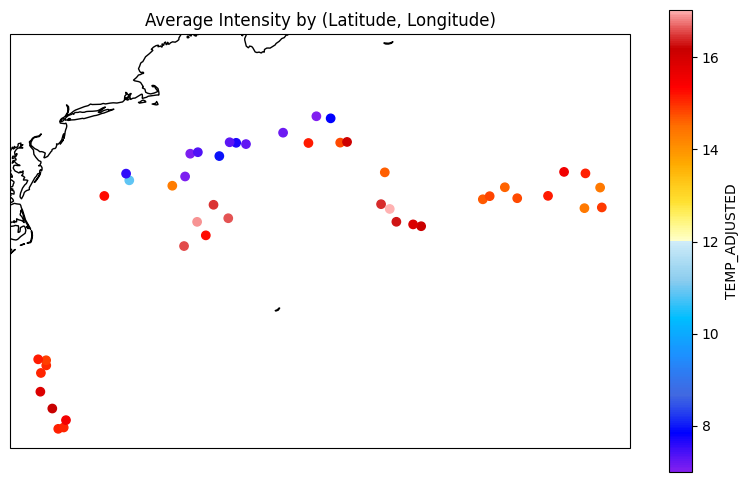

In [35]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmaps
color_map = cmaps.ncl_default

# Convert 'JULD' column to datetime type
df['JULD'] = pd.to_datetime(df['JULD'])

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED', 'JULD', and 'CHLA_ADJUSTED'
grouped = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    'JULD': lambda x: x.tolist(),  # Collect all time values into a list
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Flatten the list of time values into a single list per group (for simplicity, take the first time)
grouped['JULD'] = grouped['JULD'].apply(lambda x: x[0] if x else None)

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
plt.scatter(grouped['LONGITUDE'], grouped['LATITUDE'], c=grouped[ref_var], cmap=cmaps.ncl_default, transform=ccrs.PlateCarree())
plt.colorbar(label=ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average Intensity by (Latitude, Longitude)')
plt.grid(True)
plt.show()